In [44]:
using DataStructures
using Dates
import Random: randstring

include("src/utils.jl")

# ------------------------------

abstract type CallPolicy end

mutable struct StreamNodeBinding{TNode}
    node::TNode
    call_policy::Union{CallPolicy,Nothing}
    function StreamNodeBinding(node::TNode; call_policy::Union{CallPolicy,Nothing}=nothing) where {TNode}
        new{TNode}(node, call_policy)
    end
end

# ------------------------------

"""
A node in a stream computation graph that represents a computation step.

Types of nodes:
- **Source**: The node has no incoming edges, emits data.
- **Sink**: The node has no outgoing edges, consumes/stores data.
- **Operation**: The node has both incoming and outgoing edges, and performs a computation step.
    - **Stateful**: The node has an internal state that is updated during computation.
    - **Stateless**: The node has no internal state, and the output is a function of the input only.
"""
mutable struct StreamNode{TGraph}
    graph::TGraph
    index::Int
    is_source::Bool
    func::Function
    inputs::Vector{StreamNodeBinding{StreamNode{TGraph}}}
    output_type::Type
    init_value::Any
    label::String
    field_name::Symbol
    function StreamNode(graph::TGraph, index, is_source, func, output_type, init_value, label) where {TGraph}
        inputs = StreamNodeBinding{TGraph}[]
        field_name = Symbol("$(label)")
        new{TGraph}(graph, index, is_source, func, inputs, output_type, init_value, label, field_name)
    end
end

@inline is_source(node::StreamNode) = node.is_source
@inline is_sink(node::StreamNode) = node.output_type == Nothing

# ------------------------------

# If connected node is executed, always trigger the node
struct CallAlways <: CallPolicy
end

# Only trigger node if execution was initiated by a given source node
struct CallIfSource{TGraph} <: CallPolicy
    source_node::StreamNode{TGraph}
    CallIfSource(source_node::StreamNode{TGraph}) where {TGraph} = new{TGraph}(source_node)
end

# If connected node is executed, REGARDLESS of valid output or not, trigger the node
struct CallIfExecuted <: CallPolicy
end

# If connected node is executed, AND has a valid output, trigger the node
struct CallIfValid <: CallPolicy
end

# ------------------------------

"""
A directed acyclic graph (DAG) that represents a stream computation graph.
"""
mutable struct StreamGraph
    nodes::Vector{StreamNode{StreamGraph}}
    source_nodes::Vector{Int}
    deps::Vector{Vector{Int}}
    reverse_deps::Vector{Vector{Int}}
    topo_order::Vector{Int}
    function StreamGraph()
        new(
            StreamNode{StreamGraph}[],
            Int[],
            Vector{Int}[],
            Vector{Int}[],
            Int[]
        )
    end
end

"""
Sort the nodes in the graph in topological order using a depth-first search (DFS).
"""
function topological_sort!(graph::StreamGraph)
    visited = falses(length(graph.nodes))
    temp_stack = Int[]

    for node_index in 1:length(graph.nodes)
        if !visited[node_index]
            push!(temp_stack, node_index)

            while !isempty(temp_stack)
                current_node = temp_stack[end]

                if !visited[current_node]
                    visited[current_node] = true
                    push!(graph.topo_order, current_node)
                end

                all_visited = true

                for dependent_index in graph.deps[current_node]
                    if !visited[dependent_index]
                        push!(temp_stack, dependent_index)
                        all_visited = false
                    end
                end

                if all_visited
                    pop!(temp_stack)
                end
            end
        end
    end

    if length(graph.topo_order) != length(graph.nodes)
        error("Graph has a cycle")
    end

    nothing
end

"""
Check if the graph is weakly connected, i.e., there is a path between every pair of nodes.
If not, the graph is not fully connected and some nodes will never be reached.

Also check that there is at least one source node in the graph.
"""
function verify_graph(graph::StreamGraph)
    isempty(graph.nodes) && error("Empty graph.")
    isempty(graph.source_nodes) && error("No source nodes in the graph.")

    visited = falses(length(graph.nodes))
    stack = copy(graph.source_nodes)

    # Mark all source nodes as visited
    for source in stack
        visited[source] = true
    end

    # Perform DFS from all source nodes
    while !isempty(stack)
        node_index = pop!(stack)

        for ix in graph.reverse_deps[node_index]
            if !visited[ix]
                visited[ix] = true
                push!(stack, ix)
            end
        end
    end

    if !all(visited)
        msg = "Following nodes are not reachable from the source nodes, i.e. computation graph is not weakly connected: "
        for ix in findall(.!visited)
            msg *= "\n[$ix] $(graph.nodes[ix].label)"
        end
        error(msg)
    end
end

function _make_node_label(index::Int, func::Function, label::String)
    if isempty(label)
        label = "node #$index"
        # buffer = IOBuffer()
        # Base.show_unquoted(buffer, func)
        # label = String(take!(buffer))
    end
    label
end

function _make_node!(
    graph::StreamGraph,
    is_source::Bool,
    func::Function,
    output_type::Type,
    init_value::Any,
    label::String)
    # Array index of node in graph
    index = length(graph.nodes) + 1

    # Generate label for node
    label = _make_node_label(index, func, label)

    # Verify label is unique
    for node in graph.nodes
        node.label == label && error("Node with label '$label' already exists")
    end

    # Create node and add to graph
    node = StreamNode(graph, index, is_source, func, output_type, init_value, label)
    push!(graph.nodes, node)
    push!(graph.deps, Int[]) # The nodes that this node depends on
    push!(graph.reverse_deps, Int[]) # The nodes that depend on this node

    # Keep track of source nodes
    is_source && push!(graph.source_nodes, index)

    node
end

function op!(::Type{TOutput}, graph::StreamGraph, func::Function; init=nothing, label::String="") where {TOutput}
    _make_node!(graph, false, func, TOutput, init, label)
end

function source!(::Type{TOutput}, graph::StreamGraph; init=nothing, label::String="") where {TOutput}
    _make_node!(graph, true, identity, TOutput, init, label)
end

function sink!(graph::StreamGraph, func::Function; label::String="")
    _make_node!(graph, false, func, Nothing, nothing, label)
end

# function bind!(inputs...; to::StreamNode{TGraph}, call_policy=nothing) where {TGraph}
#     # Verify parameters
#     is_source(to) && error("Cannot bind inputs to a source node")
#     for input in inputs
#         is_sink(input) && error("Cannot bind a sink node as input")
#     end

#     # Call policy
#     if !isnothing(call_policy)
#         # Verify policy nodes are all inputs
#         for policy_node in call_policy.nodes
#             policy_node in inputs || error("Call policy node '$(policy_node.label)' is not an input")
#         end
#         to.call_policy = call_policy
#     end
    
#     graph = to.graph
#     to.inputs = collect(inputs)
#     input_indices = [input.index for input in to.inputs]
#     graph.deps[to.index] = input_indices
#     for input_index in input_indices
#         push!(graph.reverse_deps[input_index], to.index)
#     end
# end

function bind!(input::StreamNode{TGraph}, to::StreamNode{TGraph}; call_policy::Union{CallPolicy,Nothing}=nothing) where {TGraph}
    # Verify parameters
    is_source(to) && error("Cannot bind input to a source node")
    is_sink(input) && error("Cannot bind a sink node as input")

    # Default call policy
    if isnothing(call_policy)
        call_policy = CallIfValid()
    end

    # Create binding of input node to target node 
    input_binding = StreamNodeBinding(input; call_policy=call_policy)
    push!(to.inputs, input_binding)
    push!(to.graph.deps[to.index], input.index)
    push!(to.graph.reverse_deps[input.index], to.index)
    input_binding
end

# syntactic sugar for binding inputs (bind!)
# function Base.:|>(inputs, node::StreamNode{G}) where {G}
#     for (i, input) in enumerate(inputs)
#         input isa StreamNode || error("Input #$i is not a StreamNode")
#     end
#     bind!(inputs...; to=node)
#     node
# end

function Base.:|>(input::StreamNode{G}, node::StreamNode{G}) where {G}
    # bind!(input; to=node)
    bind!(input, node)
end

# ------------------------------

"""
Compile the states struct for the given graph to store intermediate results
of computation steps.
"""
function compile_states(::Type{TTime}, graph::StreamGraph) where {TTime}
    # Generate a unique name for the struct
    struct_name = Symbol("GraphStates_" * randstring(8))

    field_defs = []
    ctor_args = []

    # push!(field_defs, Expr(:(::), :__times, Vector{TTime}))
    # push!(ctor_args, :(fill(zero(TTime), $(length(graph.nodes)))))

    for (i, node) in enumerate(graph.nodes)
        # state value field
        field_type = :($(Union{node.output_type,typeof(node.init_value)}))
        push!(field_defs, Expr(:(::), node.field_name, field_type))
        push!(ctor_args, node.init_value)

        # state time field
        push!(field_defs, Expr(:(::), Symbol("$(node.field_name)__time"), TTime))
        push!(ctor_args, :(zero($TTime)))
    end

    struct_def = Expr(:struct, true, struct_name, Expr(:block, field_defs...))
    Core.eval(@__MODULE__, struct_def)

    ctor_def = :($struct_name() = $struct_name($(ctor_args...)))
    Core.eval(@__MODULE__, ctor_def)

    # println("Generated struct definition:")
    # println(struct_def)
    # println("Generated constructor:")
    # println(ctor_def)

    # Dict(zip(fieldnames(typeof(states)), fieldtypes(typeof(states))))

    getfield(@__MODULE__, struct_name)
end

# ------------------------------

struct ExecutionEvent{TTime}
    timestamp::TTime
    source_index::Int
    ExecutionEvent(timestamp::TTime, source_index::Int) where {TTime} = new{TTime}(timestamp, source_index)
end

@inline Base.isless(a::ExecutionEvent, b::ExecutionEvent) = a.timestamp < b.timestamp

# ------------------------------

abstract type StreamGraphExecutor end

"""
An executor that runs a stream computation graph in historic mode.
Historic means that the executor processes timestamped events that occurred in the past
at full speed, i.e., the current time of the executor is updated to the timestamp of the event.
"""
mutable struct HistoricExecutor{TStates,TTime} <: StreamGraphExecutor
    graph::StreamGraph
    states::TStates
    start_time::TTime
    end_time::TTime
    current_time::TTime
    event_queue::BinaryMinHeap{ExecutionEvent{TTime}}
    adapter_funcs::Vector{Function}
    function HistoricExecutor{TTime}(graph::StreamGraph, states::TStates; start_time::TTime, end_time::TTime) where {TStates,TTime}
        @assert start_time < end_time "Start time '$start_time' must be before end time '$end_time'"
        event_queue = BinaryMinHeap{ExecutionEvent{TTime}}()
        adapter_funcs = Vector{Function}()
        new{TStates,TTime}(graph, states, start_time, end_time, zero(TTime), event_queue, adapter_funcs)
    end
end

@inline function time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.current_time
end

@inline function start_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.start_time
end

@inline function end_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.end_time
end

function compile_graph!(::Type{TTime}, g::StreamGraph) where {TTime}
    # verify that the graph is weakly connected and has at least one source node
    verify_graph(g)

    # sort computation graph nodes in topological order
    topological_sort!(g)

    # compile states struct
    states_type = compile_states(TTime, g)

    # use invokelatest to call the generated states type constructor,
    # otherwise a world age error will occur because the constructor
    # is defined after the call
    states = Base.invokelatest(states_type)

    states
end

function get_source_subgraph(graph::StreamGraph, source_node::StreamNode)
    subgraph_indices = Int[]
    queue = [source_node.index]
    visited = falses(length(graph.nodes))

    while !isempty(queue)
        node_index = popfirst!(queue)
        if !visited[node_index]
            push!(subgraph_indices, node_index)
            visited[node_index] = true
            append!(queue, graph.reverse_deps[node_index])
        end
    end

    # Sort the subgraph indices according to the topological order
    sort!(subgraph_indices, by=i -> graph.topo_order[i])

    subgraph_indices
end

function _gen_execute_call!(
    executor::TExecutor,
    node_expressions::Vector{Expr},
    source_node::StreamNode{TGraph},
    node::StreamNode{TGraph},
    debug::Bool
) where {TGraph,TExecutor<:StreamGraphExecutor}
    res_name = Symbol("$(node.field_name)__res")
    input_exprs = (:(states.$(input.node.field_name)) for input in node.inputs)

    # Input bindings
    push!(node_expressions, :(should_execute = true))
    for binding in node.inputs
        debug && println("Node $(node.label): Input binding $(binding.node.label) with call policy $(typeof(binding.call_policy))")
        if binding.call_policy isa CallAlways
            # Always trigger the node, regardless of the connected node's state
        elseif binding.call_policy isa CallIfSource
            # Only trigger the node if execution was initiated by a given source node
            if binding.call_policy.source_node != source_node
                push!(node_expressions, :(should_execute &= false))
            end
        elseif binding.call_policy isa CallIfExecuted
            # Only trigger the node if the connected node has been executed in the current time step
            input_state_time_name = Symbol("$(binding.node.field_name)__time")
            push!(node_expressions, :(should_execute &= (states.$input_state_time_name == time(executor))))
        elseif binding.call_policy isa CallIfValid
            # Only trigger the node if the connected node has a valid output
            push!(node_expressions, :(should_execute &= !isnothing(states.$(binding.node.field_name))))
        else
            error("Unknown call policy for node $(node.label): $(typeof(binding.call_policy))")
        end
    end

    # Call node function
    result_expr = if debug
        :(if should_execute
            try
                # println("Executing node $($(node.label)) at time $(time(executor))...")
                result::$(node.output_type) = $(node.func)(executor, $(input_exprs...))
                # println("> output: ", result)
                result
            catch e
                error("Error in node $($(node.label)) at time $(time(executor)): $e")
            end
        else
            nothing
        end)
    else
        :(should_execute ? $(node.func)(executor, $(input_exprs...)) : nothing)
    end
    push!(node_expressions, :($res_name = $result_expr))

    # Store execution result in state variables
    state_time_field = Symbol("$(node.field_name)__time")
    push!(node_expressions, :(if !isnothing($res_name)
        # update state value of node
        states.$(node.field_name) = $res_name
        # update state time of node
        states.$state_time_field = time(executor)
    end))

    nothing
end

function compile_source!(executor::TExecutor, source_node::StreamNode{StreamGraph}; debug=false) where {TExecutor<:StreamGraphExecutor}
    graph = executor.graph
    nodes = graph.nodes

    # Find subgraph starting from given source node.
    # Nodes are returned in topological order (DFS).
    subgraph_indices = get_source_subgraph(graph, source_node)

    # Generate code for each node in the subgraph.
    # The code is generated in a block of expressions that are executed sequentially.
    node_expressions = Expr[]

    # Simply assign the input value to the state field of the source node
    push!(node_expressions, :(states.$(source_node.field_name) = event_value))

    for (i, node_index) in enumerate(subgraph_indices[2:end])
        node = nodes[node_index]
        field_name = node.field_name

        # Generate code to execute the node
        _gen_execute_call!(executor, node_expressions, source_node, node, debug)
    end

    push!(node_expressions, :(return nothing))

    func_expression = :(function(executor::$TExecutor, event_value::$(source_node.output_type))
        states = executor.states
        $(node_expressions...)
    end)

    # Create the compiled function
    compiled_func = @eval $func_expression

    # Print the clean version of the generated code
    if debug
        println("Generated code for source node $(source_node.label): ")
        _print_expression(func_expression)
        println()
    end

    compiled_func
end

function compile_historic_executor(::Type{TTime}, graph::StreamGraph; start_time::TTime, end_time::TTime, debug=false) where {TTime}
    states = compile_graph!(TTime, graph)
    executor = HistoricExecutor{TTime}(graph, states; start_time=start_time, end_time=end_time)

    # Compile source functions
    for source in executor.graph.source_nodes
        source_fn = compile_source!(executor, executor.graph.nodes[source]; debug=debug)
        push!(executor.adapter_funcs, source_fn)
    end

    executor
end

function run_simulation!(executor::HistoricExecutor{TStates,TTime}, adapters) where {TStates,TTime}
    # Initialize adapters
    setup!.(adapters, Ref(executor))

    # Process events in chronological order using a priority queue
    while !isempty(executor.event_queue)
        event = pop!(executor.event_queue)
        index = event.source_index
        timestamp = event.timestamp

        # Check if before start time
        if timestamp < start_time(executor)
            error("Event was scheduled before start time $(start_time(executor))")
        end

        # Check if past end time
        if timestamp > end_time(executor)
            println("Simulation ended at time $(time(executor))")
            break
        end

        # Update the current time of the executor
        executor.current_time = timestamp

        # Execute
        advance!(adapters[index], executor)
        # event.func()
    end

    nothing
end

# ------------------------------

mutable struct IterableAdapter{TData,TSoureFunc}
    node::StreamNode{StreamGraph}
    adapter_func::TSoureFunc
    data::TData
    position::Int
    function IterableAdapter(executor, node::StreamNode{StreamGraph}, data::TData; start_index=1) where {TData}
        adapter_func = executor.adapter_funcs[node.index]
        new{TData,typeof(adapter_func)}(node, adapter_func, data, start_index)
    end
end

function setup!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    if adapter.position > length(adapter.data)
        return # Empty or no more data available
    end

    # Schedule first record
    timestamp, _ = adapter.data[adapter.position]
    push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))
end

function advance!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    # Execute subgraph based on current value
    timestamp, input_data = adapter.data[adapter.position]
    adapter.adapter_func(executor, input_data)

    # Schedule next record
    if adapter.position < length(adapter.data)
        adapter.position += 1
        timestamp, _ = adapter.data[adapter.position]
        push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))
    end
end

# ------------------------------

mutable struct TimerAdapter{TPeriod,TTime,TSoureFunc}
    node::StreamNode{StreamGraph}
    adapter_func::TSoureFunc
    interval::TPeriod
    current_time::TTime
    function TimerAdapter{TTime}(executor, node::StreamNode{StreamGraph}; interval::TPeriod, start_time::TTime) where {TPeriod,TTime}
        adapter_func = executor.adapter_funcs[node.index]
        new{TPeriod,TTime,typeof(adapter_func)}(node, adapter_func, interval, start_time)
    end
end

function setup!(timer::TimerAdapter{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Initialize current time of the timer
    if timer.current_time < start_time(executor)
        timer.current_time = start_time(executor)
    end

    if timer.current_time > end_time(executor)
        return
    end

    # Schedule first event
    push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))
end

function advance!(timer::TimerAdapter{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Execute subgraph based on current value
    timer.adapter_func(executor, timer.current_time)

    # Schedule next event
    timer.current_time += timer.interval
    if timer.current_time <= end_time(executor)
        push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))
    end
end

advance! (generic function with 2 methods)

Time-based bucket aggregation

In [49]:
g = StreamGraph()

# Create source nodes
source_timer = source!(DateTime, g; label="source_timer")
source_values = source!(Float64, g; label="source_values")

mutable struct Buffer{T}
    values::Vector{T}
    function Buffer{T}() where T
        new{T}(T[])
    end
end
(op::Buffer)(val) = begin
    push!(op.values, val)
    op
end
Base.empty!(op::Buffer) = empty!(op.values)
values(op::Buffer) = op.values

node_buffer = op!(Buffer{Float64}, g, (exe, x) -> buffer(x); init=Buffer{Float64}(), label="buffer")
last_dt = DateTime(2000, 1, 1, 0, 0, 0)
flush_buffer = op!(Union{Vector{Float64},Nothing}, g, function(exe, buf, dt)
    vals = copy(values(buf))
    empty!(buf)
    vals
end, label="flush_buffer")

# Create sink nodes
output1 = sink!(g, (exe, x) -> println("output #1 at time $(time(exe)): $x"); label="output1")

# Create edges between nodes (define the computation graph)
bind!(source_values, node_buffer)
bind!(node_buffer, flush_buffer; call_policy=CallIfSource(source_timer))
bind!(source_timer, flush_buffer; call_policy=CallAlways())
bind!(flush_buffer, output1; call_policy=CallIfSource(source_timer))

exe = compile_historic_executor(DateTime, g; start_time=DateTime(2000, 1, 1, 0, 0, 0), end_time=DateTime(2000, 1, 1, 0, 0, 20), debug=!true)

adapters = [
    TimerAdapter{DateTime}(exe, source_timer; interval=Dates.Second(5), start_time=start_time(exe)),
    IterableAdapter(exe, source_values, [
        (DateTime(2000, 1, 1, 0, 0, 1), 1.0),
        (DateTime(2000, 1, 1, 0, 0, 2), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 7), 7.0),
        (DateTime(2000, 1, 1, 0, 0, 10), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 15), 15.0),
        (DateTime(2000, 1, 1, 0, 0, 16), 16.0),
    ]),
]
@time run_simulation!(exe, adapters)

output #1 at time 2000-01-01T00:00:00: Float64[]
output #1 at time 2000-01-01T00:00:05: [1.0, 2.0, 4.0]
output #1 at time 2000-01-01T00:00:10: [7.0]
output #1 at time 2000-01-01T00:00:15: [10.0]
output #1 at time 2000-01-01T00:00:20: [15.0, 16.0]
  0.105707 seconds (161.97 k allocations: 10.998 MiB, 99.69% compilation time)


First demo graph

In [ ]:
g = StreamGraph()

# Create source nodes
source1 = source!(Float64, g; label="source1")
source2 = source!(Float64, g; label="source2")
source3 = source!(Float64, g; label="source3")

# Create compute nodes
square = op!(Float64, g, (exe, x) -> x^2; init=0.0, label="square")
divide_by_2 = op!(Float64, g, (exe, x) -> x / 2; init=0.0, label="divide_by_2")
negate = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate")
combine = op!(Tuple{Float64,Float64}, g, (exe, x, y) -> (x, y); init=(0.0, 0.0), label="combine")
final_multiply = op!(Tuple{Float64,Float64}, g, (exe, tuple, src2, src3) -> tuple .* src2 .+ src3; label="final_multiply")

# Create sink nodes
output1 = sink!(g, (exe, x) -> println("output #1 at time $(time(exe)): $x"); label="output1")
# output2 = sink!(g, (exe, x) -> println("output #2 at time $(time(exe)): $x"); label="output2")
output2 = sink!(g, (exe, x) -> nothing; label="output2")

# Create edges between nodes (define the computation graph)
source1 |> square
square |> divide_by_2
source2 |> negate
(divide_by_2, negate) |> combine
(combine, source2, source3) |> final_multiply
final_multiply |> output1
combine |> output2

exe = compile_historic_executor(DateTime, g; start_time=DateTime(2000, 1, 1, 0, 0, 1), end_time=DateTime(2000, 1, 1, 0, 0, 6))

adapters = [
    IterableAdapter(exe, source1, [
        (DateTime(2000, 1, 1, 0, 0, 1), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 3), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 5), 6.0)
    ]),
    IterableAdapter(exe, source2, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ]),
    IterableAdapter(exe, source3, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ])
]
run_simulation!(exe, adapters)

In [ ]:
# using BenchmarkTools
# dt = DateTime(2000, 1, 1, 0, 0, 2)
# @benchmark process!($exe, $src2_fn, $dt, 10.0) samples=500 evals=2

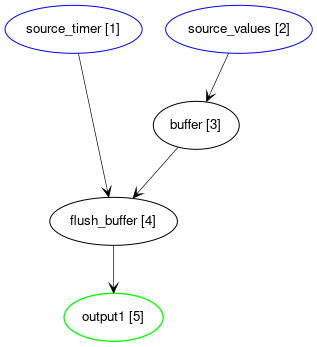

In [39]:
import ShowGraphviz

function graphviz(graph::StreamGraph; fontsize=10)
    io = IOBuffer()
    
    println(io, "digraph G {")
    println(io, "  node [fontsize=$fontsize, fontname=\"Helvetica,Arial,sans-serif\"];")
    
    function make_label(node::StreamNode)
        return "$(node.label) [$(node.index)]"
    end

    # Source nodes (at the top)
    println(io, "  { rank=source; ")
    for node in filter(is_source, graph.nodes)
        println(io, "    node$(node.index) [label=\"$(make_label(node))\", shape=ellipse, color=blue, penwidth=0.75];")
    end
    println(io, "  }")

    # Computation nodes
    for node in graph.nodes
        if !is_source(node) && !is_sink(node)
            println(io, "  node$(node.index) [label=\"$(make_label(node))\", shape=ellipse, color=black, penwidth=0.75];")
        end
    end

    # Sink nodes (at the bottom)
    println(io, "  { rank=sink; ")
    for node in filter(is_sink, graph.nodes)
        println(io, "    node$(node.index) [label=\"$(make_label(node))\", shape=ellipse, color=green, penwidth=1];")
    end
    println(io, "  }")
    
    # Add edges to the graph
    for (i, node) in enumerate(graph.nodes)
        for input_binding in node.inputs
            println(io, "  node$(input_binding.node.index) -> node$(node.index) [arrowhead=open, penwidth=0.5, arrowsize=0.75];")
        end
    end
    
    println(io, "}") # end digraph
    
    dot_code = String(take!(io))
    ShowGraphviz.DOT(dot_code)
end

graphviz(exe.graph)

In [ ]:
g = StreamGraph()

# Create source nodes
source2 = source!(Float64, g; init=0.0, label="source2")

# Create compute nodes
negate1 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate1")
multiply = op!(Float64, g, (exe, x) -> 5x; init=0.0, label="multiply")
combine = op!(Tuple{Float64,Float64}, g, (exe, x, y) -> (x, y); init=(0.0, 0.0), label="combine")
negate2 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate2")
negate3 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate3")
final_multiply = op!(Tuple{Float64,Float64}, g, (exe, tuple, src2, src3) -> tuple .* src2 .+ src3; init=(0.0, 0.0), label="final_multiply")

# Create sink nodes
output1 = sink!(g, (exe, x) -> println("output #1 at time $(time(exe)): $x"); label="output1")
output2 = sink!(g, (exe, x) -> println("output #2 at time $(time(exe)): $x"); label="output2")
output3 = sink!(g, (exe, x) -> println("output #3 at time $(time(exe)): $x"); label="output3")

# Create edges between nodes (define the computation graph)
source2 |> negate1
source2 |> multiply
(negate1, multiply) |> combine
(combine, source2) |> final_multiply
final_multiply |> output1
combine |> negate2
negate2 |> negate3
negate3 |> output2
negate2 |> output3

exe = compile_historic_executor(DateTime, g; start_time=DateTime(2000, 1, 1, 0, 0, 1), end_time=DateTime(2000, 1, 1, 0, 0, 6))

graphviz(exe.graph)